In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.api import OLS
import seaborn as sns

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

In [2]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_by_month`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


In [3]:
apple = query_ticker_data('AAPL').set_index('date')
netflix = query_ticker_data('NFLX').set_index('date')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_by_month` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard").set_index('date')
fb = query_ticker_data('FB').set_index('date')
fb_meta = pd.concat([meta, fb])
microsoft = query_ticker_data('MSFT').set_index('date')
amazon = query_ticker_data('AMZN').set_index('date')
alphabet = query_ticker_data('GOOGL').set_index('date')
coke = query_ticker_data('KO').set_index('date')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
fb_meta.name = "Facebook / Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [4]:
TARGET_DF = apple

In [5]:
TARGET_DF['lag_1'] = TARGET_DF['volume_weighted_average_price'].shift(1)

In [10]:
X = TARGET_DF.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = TARGET_DF.loc[:, 'volume_weighted_average_price']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target
model = OLS(y,X)
fitted = model.fit()
y_pred = pd.Series(fitted.predict(X), index=X.index)

In [11]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     volume_weighted_average_price   R-squared (uncentered):                   0.996
Model:                                       OLS   Adj. R-squared (uncentered):              0.996
Method:                            Least Squares   F-statistic:                          1.396e+04
Date:                           Sat, 21 Oct 2023   Prob (F-statistic):                    8.40e-72
Time:                                   13:50:45   Log-Likelihood:                         -211.71
No. Observations:                             60   AIC:                                      425.4
Df Residuals:                                 59   BIC:                                      427.5
Df Model:                                      1                                                  
Covariance Type:                       nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          1.0127      0.009    118.168      0.000       0.996       1.030
==============================================================================
Omnibus:                        0.325   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.082
Skew:                          -0.087   Prob(JB):                        0.960
Kurtosis:                       3.052   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='lag_1', ylabel='volume_weighted_average_price'>

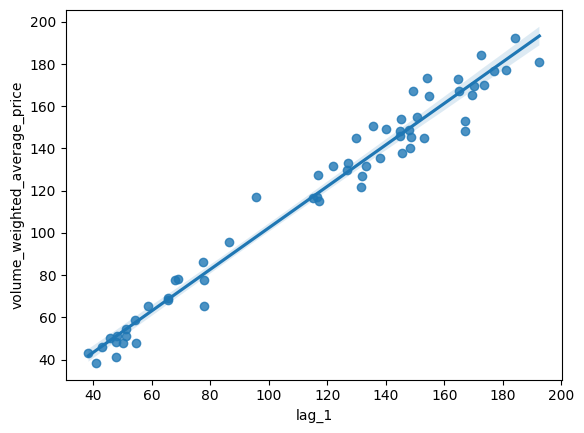

In [17]:
sns.regplot(x='lag_1', y='volume_weighted_average_price', data=TARGET_DF)